Блок предобработки временного ряда

Свойства временных рядов

In [230]:
import pandas as pd
df = pd.read_csv('data\climate.csv')
df['Date'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
selected_columns = ['Date', 'wv (m/s)', 'Tpot (K)', 'H2OC (mmol/mol)']
df = df[selected_columns]
df = df[:15000]
df.dtypes
df.corr()

,Date,wv (m/s),Tpot (K),H2OC (mmol/mol)
Date,1.000000,0.112434,0.731123,0.725094
wv (m/s),0.112434,1.000000,0.270273,0.102631
Tpot (K),0.731123,0.270273,1.000000,0.903168
H2OC (mmol/mol),0.725094,0.102631,0.903168,1.000000


In [231]:
# Анализ на наличие пропущенных значений
missing_values = df.isnull().sum()
print("Пропущенные значения:")
print(missing_values)


Пропущенные значения:
Date               0
wv (m/s)           0
Tpot (K)           0
H2OC (mmol/mol)    0
dtype: int64


In [232]:
# Определение межквартильного размаха
Q1 = df.quantile(0.05)
Q3 = df.quantile(0.95)
IQR = Q3 - Q1

# Поиск выбросов
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
outliers_count = outliers.sum()
print("Количество выбросов в каждом столбце:")
print(outliers_count)

Количество выбросов в каждом столбце:
Date               0
wv (m/s)           4
Tpot (K)           0
H2OC (mmol/mol)    0
dtype: int64


In [233]:
df.describe()

,Date,wv (m/s),Tpot (K),H2OC (mmol/mol)
count,15000,15000.000000,15000.000000,15000.000000
mean,2009-02-22 02:05:00,2.054101,276.047941,5.970514
min,2009-01-01 00:10:00,0.000000,250.600000,0.800000
25%,2009-01-27 01:07:30,0.930000,271.980000,4.490000
50%,2009-02-22 02:05:00,1.780000,276.130000,5.760000
75%,2009-03-20 03:02:30,2.800000,279.890000,7.110000
max,2009-04-15 04:00:00,12.960000,297.890000,13.120000
std,NaN,1.491906,7.011147,2.218331


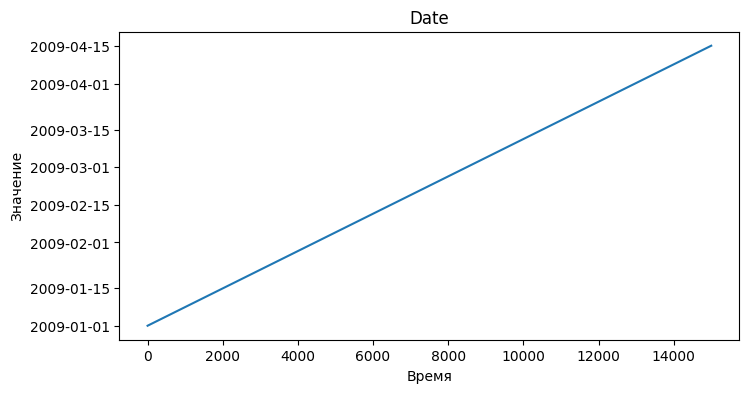

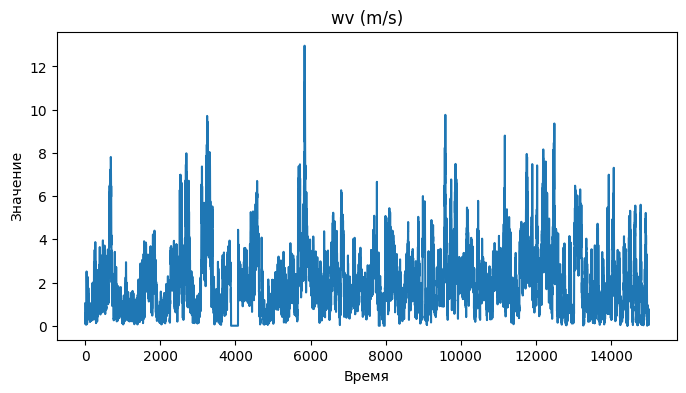

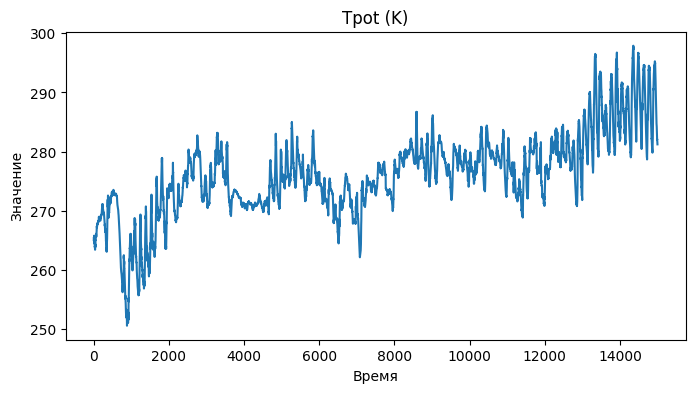

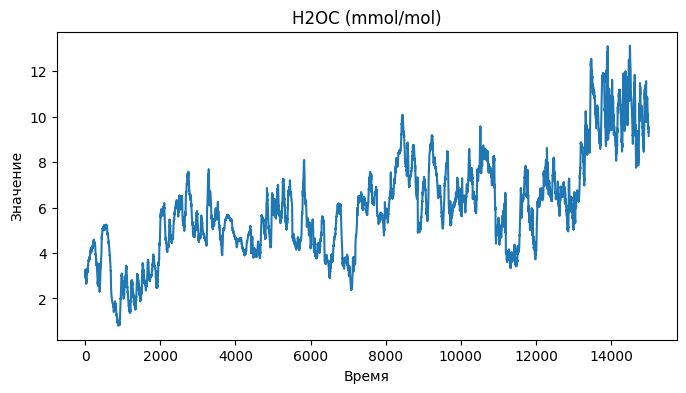

In [234]:
import matplotlib.pyplot as plt
columns = df.columns
for column in columns:
        plt.figure(figsize=(8, 4))
        plt.plot(df[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

In [235]:
time_diff = df['Date'].diff()
time_diff.unique()

<TimedeltaArray>
[NaT, '0 days 00:10:00']
Length: 2, dtype: timedelta64[ns]

In [236]:
from statsmodels.tsa.stattools import adfuller
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [237]:
for col in df.columns:
    if col != 'Date/Time':
        df_test(col, df[col])

Тест Дики-Фуллера ряда Date:
Test Statistic                    -0.015012
p-value                            0.957273
#Lags Users                       36.000000
Number of Observations Used    14963.000000
Critical Value (1%)               -3.430787
Critical Value (5%)               -2.861733
Critical Value (10%)              -2.566873
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.
Тест Дики-Фуллера ряда wv (m/s):
Test Statistic                -1.213919e+01
p-value                        1.666136e-22
#Lags Users                    2.000000e+01
Number of Observations Used    1.497900e+04
Critical Value (1%)           -3.430787e+00
Critical Value (5%)           -2.861733e+00
Critical Value (10%)          -2.566873e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Tpot (K):
Test Statistic                    -5.545978
p-value                            0.000002
#Lags Users                       42.000000
Number of Observations Used    14957.000

В моделях VAR и VARMA стационарность данных является важным условием для точного прогнозирования, тогда как для нейронных сетей это необязательно.

Коинтеграция

Коинтеграция временных рядов – причинно-следственная зависимость в уровнях двух и более временных рядов, которая выражается в совпадении или противоположной направленности тенденций данных рядов и случайной колеблемости.

Если временные ряды коинтегрированы, это обычно означает, что можно строить модели, учитывающие их долгосрочные взаимосвязи для лучших предсказаний (VAR, VARMA и т.д.).

In [238]:
from itertools import combinations
from statsmodels.tsa.stattools import coint

del df['Date']
pairs = combinations(df.columns, 2)

for pair in pairs:
    pair_data = df[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между wv (m/s) и Tpot (K)
Есть коинтеграция между wv (m/s) и H2OC (mmol/mol)
Есть коинтеграция между Tpot (K) и H2OC (mmol/mol)


Причинность рядов по Грейнджеру - это статистический тест, который используется для определения причинно-следственной связи между двумя временными рядами. Тест Грейнджера позволяет определить, может ли один временной ряд использоваться для прогнозирования другого ряда. Этот подход основан на идее, что если временной ряд X вызывает изменения в другом ряду Y, то значения X должны предшествовать значениям Y

In [239]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=12):
    data_granger = pd.DataFrame(0, columns=variables, index=variables)
    
    for var in variables:
        for var2 in variables:
            results = grangercausalitytests(data[[var, var2]], maxlag=maxlag, verbose=False)
            p_values = [round(results[i+1][0][test][1], 4) for i in range(maxlag)]
            data_granger.loc[var, var2] = np.min(p_values)
    return data_granger


grangers_causation_matrix(df,variables=df.columns)

c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.

,wv (m/s),Tpot (K),H2OC (mmol/mol)
wv (m/s),1,0,0
Tpot (K),0,1,0
H2OC (mmol/mol),0,0,1


Если значение p-уровня значимости, полученное в результате теста Грейнджера, близко к нулю или строго равно нулю (< 0.05) для пары временных рядов, это обычно рассматривается как сильное статистическое подтверждение наличия причинной связи между этими рядами. Такие результаты свидетельствуют о том, что изменения в одном временном ряде действительно влияют на изменения в другом ряде, что делает VAR модели более подходящими для моделирования таких взаимосвязей

Прогнозирование временного ряда методами классик мл

Модель VAR (Vector AutoRegression) - это статистическая модель временных рядов, предназначенная для прогнозирования изменений в нескольких взаимосвязанных переменных в течение времени. Она представляет собой многомерное расширение модели авторегрессии (AR).

VAR моделирует каждую переменную как линейную комбинацию ее предыдущих значений и предыдущих значений других переменных. Это позволяет улучшить прогнозы путем учета взаимосвязей между переменными.

В начале анализа мы можем подобрать оптимальный порядок модели, используя информационные критерии, такие как AIC (Критерий информационной акайке), BIC (Байесовский информационный критерий), FPE (Финальная ошибка прогнозирования) и HQC (Критерий Ханнана-Квинна). Меньшие значения этих критериев указывают на более подходящую модель, и их можно использовать для выбора оптимального порядка модели VAR.

In [240]:
from statsmodels.tsa.vector_ar.var_model import VAR
train, test = df[:10000], df[10000:]

model = VAR(train)

orders = [2, 6, 12, 20, 24, 30, 40, 48, 50, 96, 168, 252, 336]
criteria = ['aic', 'bic', 'fpe', 'hqic']

best_order = {}
best_values = {}
for crit in criteria:
    best_order[crit] = None
    best_values[crit] = np.inf

for i in orders:
    result = model.fit(i)
    for crit in criteria:
        value = getattr(result, crit)
        if value < best_values[crit]:
            best_values[crit] = value
            best_order[crit] = i

for crit in criteria:
    print(f'Optimal lag order chosen by {crit}: {best_order[crit]}, {crit} value: {best_values[crit]}')


Optimal lag order chosen by aic: 12, aic value: -11.698987591098884
Optimal lag order chosen by bic: 6, bic value: -11.632951438019068
Optimal lag order chosen by fpe: 12, fpe value: 8.302220993106857e-06
Optimal lag order chosen by hqic: 12, hqic value: -11.67186668523723


Обучаем модель с наилучшим порядком 12

In [241]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 13, Jan, 2024
Time:                     01:06:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.6189
Nobs:                     9988.00    HQIC:                  -11.6719
Log likelihood:           16018.7    FPE:                8.30222e-06
AIC:                     -11.6990    Det(Omega_mle):     8.21064e-06
--------------------------------------------------------------------
Results for equation wv (m/s)
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -1.609720         0.543382           -2.962           0.003
L1.wv (m/s)                 0.825784         0.010195           81.000           0.000
L1.Tpot (K)                 0.163

Теперь мы подготовим данные для проведения тестов и выполнения предсказаний.

In [242]:
def create_dataset(data, in_seq_order, for_len=1, step=1):
    X = []
    Y = []
    for i in range(0, len(data) - for_len - in_seq_order, step):
        X.append(data[i:(i+in_seq_order)].to_numpy())
        Y.append(data[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X, Y


In [244]:
X_test, Y_test = create_dataset(test, 12)
X_train, Y_train = create_dataset(train, 12)

In [245]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [246]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

In [247]:
from numpy import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

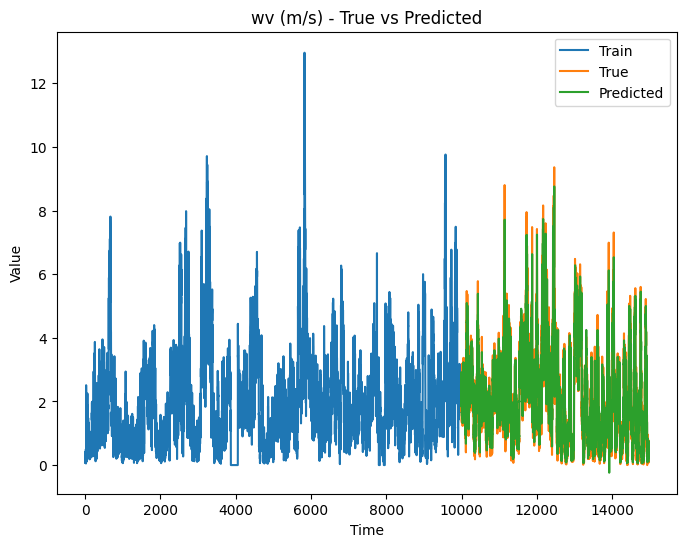

Метрики wv (m/s)
MSE: 0.3102956361625264
RMSE: 0.5570418621275482
MAE: 0.3981684535910479
SMAPE: 0.062
R2: 0.8599596119747841 



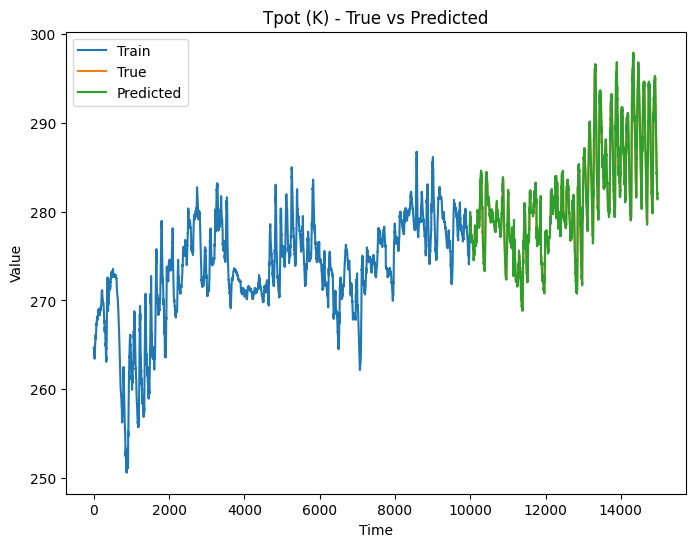

Метрики Tpot (K)
MSE: 0.04759784725537462
RMSE: 0.21816930869252582
MAE: 0.13523996712714648
SMAPE: 0.0
R2: 0.9986762289819267 



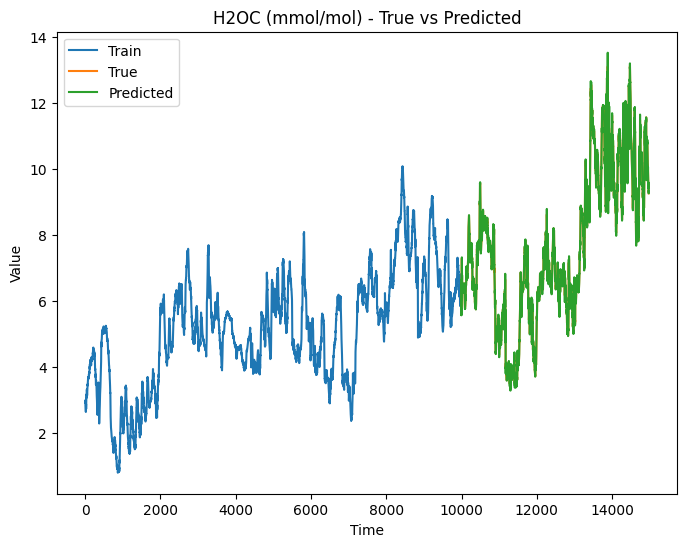

Метрики H2OC (mmol/mol)
MSE: 0.012473803332178497
RMSE: 0.11168618236907597
MAE: 0.06501039248155863
SMAPE: 0.002
R2: 0.997490519625071 



In [248]:
plot_and_metrics(df.columns, Y_test, Y_pred, Y_train)

Метрики демонстрируют хорошую качества модели: значение MSE, RMSE и MAE ниже 1, что является приемлемым, а иногда и приближается к 0. SMAPE также хорошо себя показывает, приближаясь к нулю, что является идеальным результатом. Значение R2 около 0.99, подтверждая высокую точность модели, приближаясь к единице, что отлично.

VARMA (Vector AutoRegressive Moving-Average) - это модель, применяемая в анализе временных рядов для описания взаимозависимостей между несколькими временными рядами. В контексте VARMA, каждый временной ряд в системе рассматривается как комбинация своих предыдущих значений (авторегрессия) и лагированных ошибок прогнозирования (скользящая средняя). Важно отметить, что VARMA представляет собой обобщение модели ARMA, расширяя её на случай многомерных данных.

В модели ARMA (AutoRegressive Moving Average), каждый временной ряд моделируется на основе его собственных предыдущих значений (авторегрессионный компонент) и предыдущих ошибок прогнозирования (скользящая средняя компонент).

Таким образом, VARMA предполагает, что изменения в одном временном ряде могут влиять на изменения в другом временном ряде, и наоборот. Эта модель часто используется для анализа и прогнозирования временных рядов, когда взаимодействие между переменными играет ключевую роль. Это как раз наш случай

In [249]:
X = df
train, test = X[:10000], X[10000:]

In [31]:
pip install joblib #для паралельной работы


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#для'


In [250]:
from pmdarima import auto_arima
from joblib import Parallel, delayed

def find_order(name, data):
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data, start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False,
                                trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    return parameter

pq = Parallel(n_jobs=-1)(delayed(find_order)(name, column) for name, column in df.items())



In [251]:
pq

[(3, 1, 1), (7, 1, 1), (4, 1, 3)]

Подберем наилучший порядок

In [252]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

df_results_moni = pd.DataFrame(columns=['p', 'q', 'RMSE wv (m/s)', 'RMSE Tpot (K)', 'RMSE H2OC (mmol/mol)'])
results_list = []

for i in pq:
    if i[0] == 0 and i[2] == 0:
        pass
    else:
        model = VARMAX(train, order=(i[0], 0, i[2])).fit(disp=False)
        result = model.forecast(steps=len(test))
        
        rmse_wv = np.sqrt(metrics.mean_squared_error(test['wv (m/s)'], result['wv (m/s)']))
        rmse_tpot = np.sqrt(metrics.mean_squared_error(test['Tpot (K)'], result['Tpot (K)']))
        rmse_h2oc = np.sqrt(metrics.mean_squared_error(test['H2OC (mmol/mol)'], result['H2OC (mmol/mol)']))
        
        results_list.append({'p': i[0], 'q': i[2], 'RMSE wv (m/s)': rmse_wv, 'RMSE Tpot (K)': rmse_tpot, 'RMSE H2OC (mmol/mol)': rmse_h2oc})

df_results_moni = pd.DataFrame(results_list)


In [253]:
df_results_moni.sort_values(by=['RMSE wv (m/s)', 'RMSE Tpot (K)', 'RMSE H2OC (mmol/mol)'])


,p,q,RMSE wv (m/s),RMSE Tpot (K),RMSE H2OC (mmol/mol)
0,3,1,1.497528,10.076563,3.308162
2,4,3,1.500784,10.202842,3.338537
1,7,1,1.503048,10.241876,3.348584


Наилучшие p, q - 3,1

In [254]:
model = VARMAX(train, order=(3,1)).fit(disp=False)
result = model.forecast(steps=len(test))
result

c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


,wv (m/s),Tpot (K),H2OC (mmol/mol)
10000,2.061823,278.039204,6.395567
10001,2.070399,278.011111,6.374785
10002,2.071103,278.004102,6.363581
10003,2.086798,277.998118,6.357010
10004,2.101446,277.990766,6.353197
...,...,...,...
14995,1.938101,272.737705,4.969069
14996,1.938100,272.737691,4.969064
14997,1.938099,272.737678,4.969060
14998,1.938098,272.737664,4.969056


Посчитаем метрики и выведем предсказания

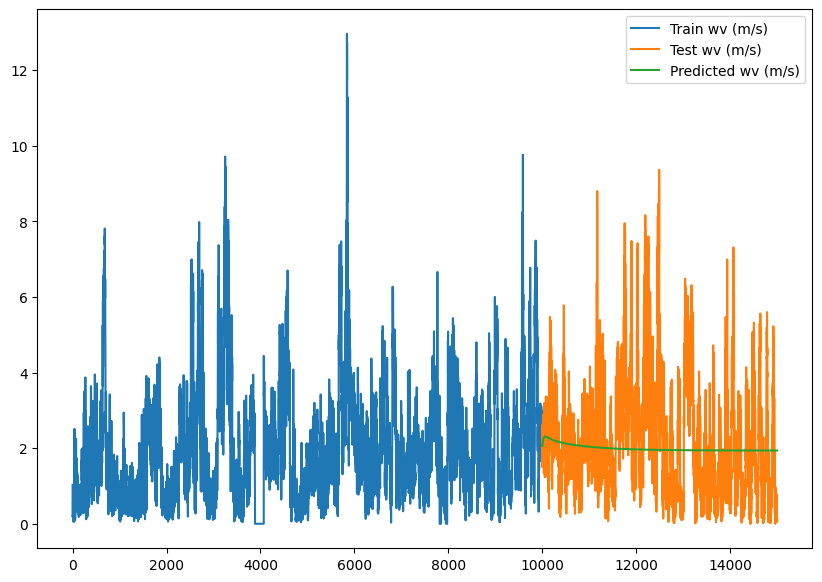

Evaluation metric for wv (m/s) Metrics:
MSE: 2.2536288523832853
MAE: 1.1698449229045345
RMSE: 1.5012091301292052
SMAPE: 0.148
R2: -0.01919832720728798



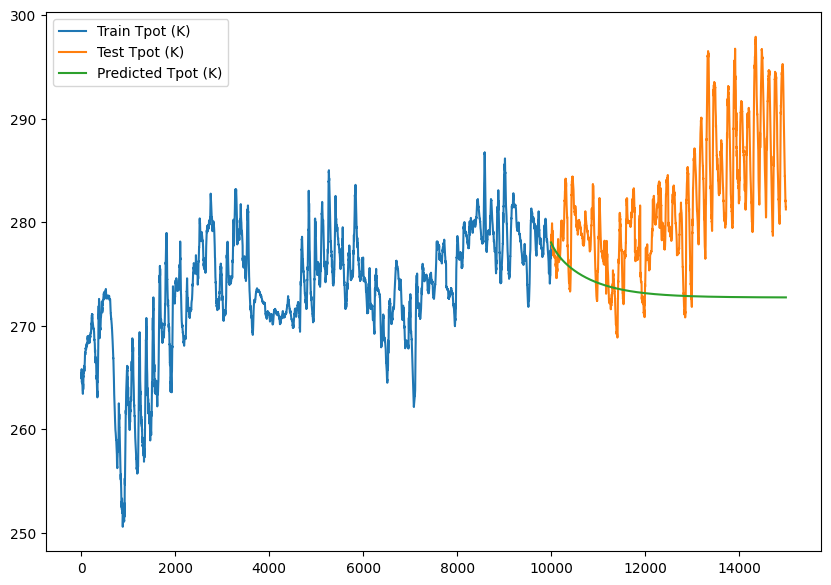

Evaluation metric for Tpot (K) Metrics:
MSE: 107.58082575870398
MAE: 8.367102980017359
RMSE: 10.372117708486728
SMAPE: 0.007
R2: -1.9975761043605664



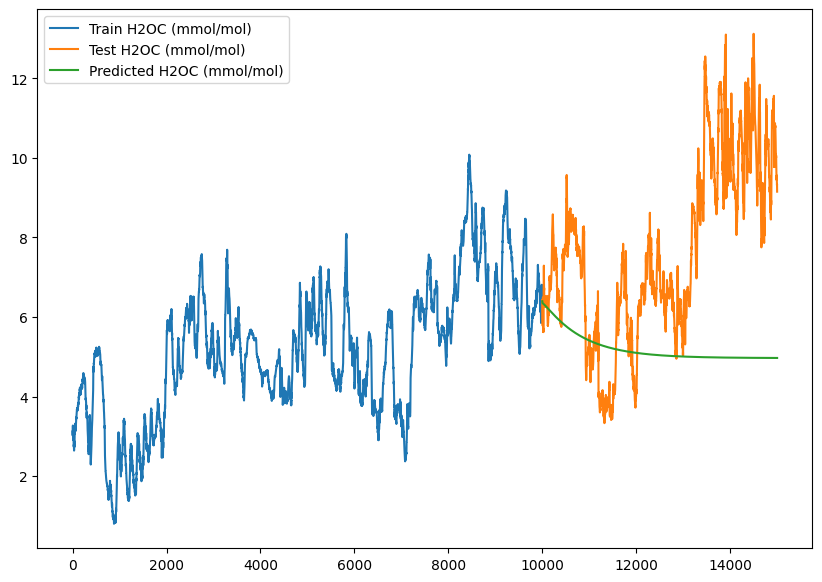

Evaluation metric for H2OC (mmol/mol) Metrics:
MSE: 11.482091124485645
MAE: 2.713076767977151
RMSE: 3.388523443106989
SMAPE: 0.097
R2: -1.312769476230717



In [255]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def timeseries_evaluation_metrics_func(y_true, y_pred, metric_name):
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    smape = smape_score(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print(f'{metric_name} Metrics:')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'SMAPE: {smape}')
    print(f'R2: {r2}\n')

columns_to_plot = ['wv (m/s)', 'Tpot (K)', 'H2OC (mmol/mol)']

for column in columns_to_plot:
    plt.rcParams["figure.figsize"] = [10, 7]
    plt.plot(train[column], label=f'Train {column}')
    plt.plot(range(10000, 15000), test[column], label=f'Test {column}')
    plt.plot(range(10000, 15000), result[column], label=f'Predicted {column}')
    plt.legend(loc='best')
    plt.show()

    timeseries_evaluation_metrics_func(test[column], result[column], f'Evaluation metric for {column}')



Анализ метрик для каждого временного ряда:

Метрики для H2OC (mmol/mol) и wv (m/s) имеют низкие значения MSE и MAE, что говорит о хорошей точности прогноза для этих переменных.
Для Tpot (K) метрики MSE и RMSE являются относительно высокими, а R2 отрицательным, что может указывать на менее удовлетворительную точность модели для этой переменной.
SMAPE показывает процентное отклонение, и близкое к нулю значение свидетельствует о хорошей точности прогноза.
Итак, несмотря на некоторые проблемы с Tpot (K), модель обладает хорошей точностью для H2OC (mmol/mol) и wv (m/s). Необходимо также учитывать контекст и специфику данных при интерпретации результатов.

## Нейросети

LSTM (Long Short-Term Memory) представляет собой архитектуру нейронной сети, специально разработанную для обработки последовательных данных, где важны зависимости в различные моменты времени. Она является подтипом рекуррентных нейронных сетей (RNN) и успешно решает проблемы, связанные с долгосрочными зависимостями и затуханием градиентов.

In [ ]:
pip install torch

  Using cached torch-2.1.2-cp310-cp310-win_amd64.whl.metadata (26 kB)
Using cached torch-2.1.2-cp310-cp310-win_amd64.whl (192.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [295]:
columns_to_use = ['wv (m/s)', 'Tpot (K)', 'H2OC (mmol/mol)']


In [311]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_lstm_dataset(data, columns, lookback_window):
    """
    Создает обучающий набор данных для LSTM.

    Parameters:
    - data (pd.DataFrame or np.ndarray): Исходный DataFrame или массив NumPy.
    - columns (list): Список столбцов для использования в обучающем наборе данных.
    - lookback_window (int): Размер окна истории.

    Returns:
    - x (np.ndarray): Входные данные для LSTM.
    - y (np.ndarray): Целевые данные для LSTM.
    """

    # Преобразование в DataFrame, если это массив NumPy
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=columns)

    # Создание DataFrame из выбранных столбцов
    df_lstm = data[columns]

    # Преобразование в массив NumPy
    df_lstm_array = df_lstm.values

    # Инициализация MinMaxScaler для нормализации
    scaler = MinMaxScaler()

    # Подготовка данных для LSTM
    x, y = [], []
    for i in range(lookback_window, len(df_lstm_array)):
        x.append(df_lstm_array[i - lookback_window:i])
        y.append(df_lstm_array[i])
    
    # Преобразование в массивы NumPy
    x = np.array(x)
    y = np.array(y)

    return x, y

# Пример использования функции
lookback_window = 1

x, y = create_lstm_dataset(df.values, columns_to_use, lookback_window)

In [312]:
x_train = x[0:10000]
y_train = y[0:10000]
x_test = x[10000:]
y_test = y[10000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 3)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3)).reshape(x_test.shape)


In [313]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input, Model

def build_lstm_model(lookback_window, num_features, units=90):
    """
    Строит модель LSTM.

    Parameters:
    - lookback_window (int): Размер окна истории.
    - num_features (int): Количество признаков в каждом временном шаге.
    - units (int): Количество нейронов в слое LSTM.

    Returns:
    - model (tf.keras.Model): Построенная модель LSTM.
    """

    # Входной слой
    i = Input(shape=(lookback_window, num_features))

    # LSTM слой
    m = LSTM(units=units, activation='tanh', return_sequences=False)(i)

    # Полносвязный слой
    m = Dense(num_features, activation='linear')(m)

    # Создание модели
    model = Model(inputs=[i], outputs=[m])

    return model

# Размер окна истории и количество признаков
lookback_window = 1
num_features = 3

# Построение модели
model = build_lstm_model(lookback_window, num_features)

# Вывод структуры модели
model.summary()

# Компиляция модели
model.compile(optimizer='adam', loss='mae')


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 1, 3)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 90)                33840     
                                                                 
 dense_25 (Dense)            (None, 3)                 273       
                                                                 
Total params: 34113 (133.25 KB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [314]:
model.fit(x_train_scaled, y_train_scaled, epochs=30, verbose=0)
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 3))

157/157 [==============================] - 1s 3ms/step


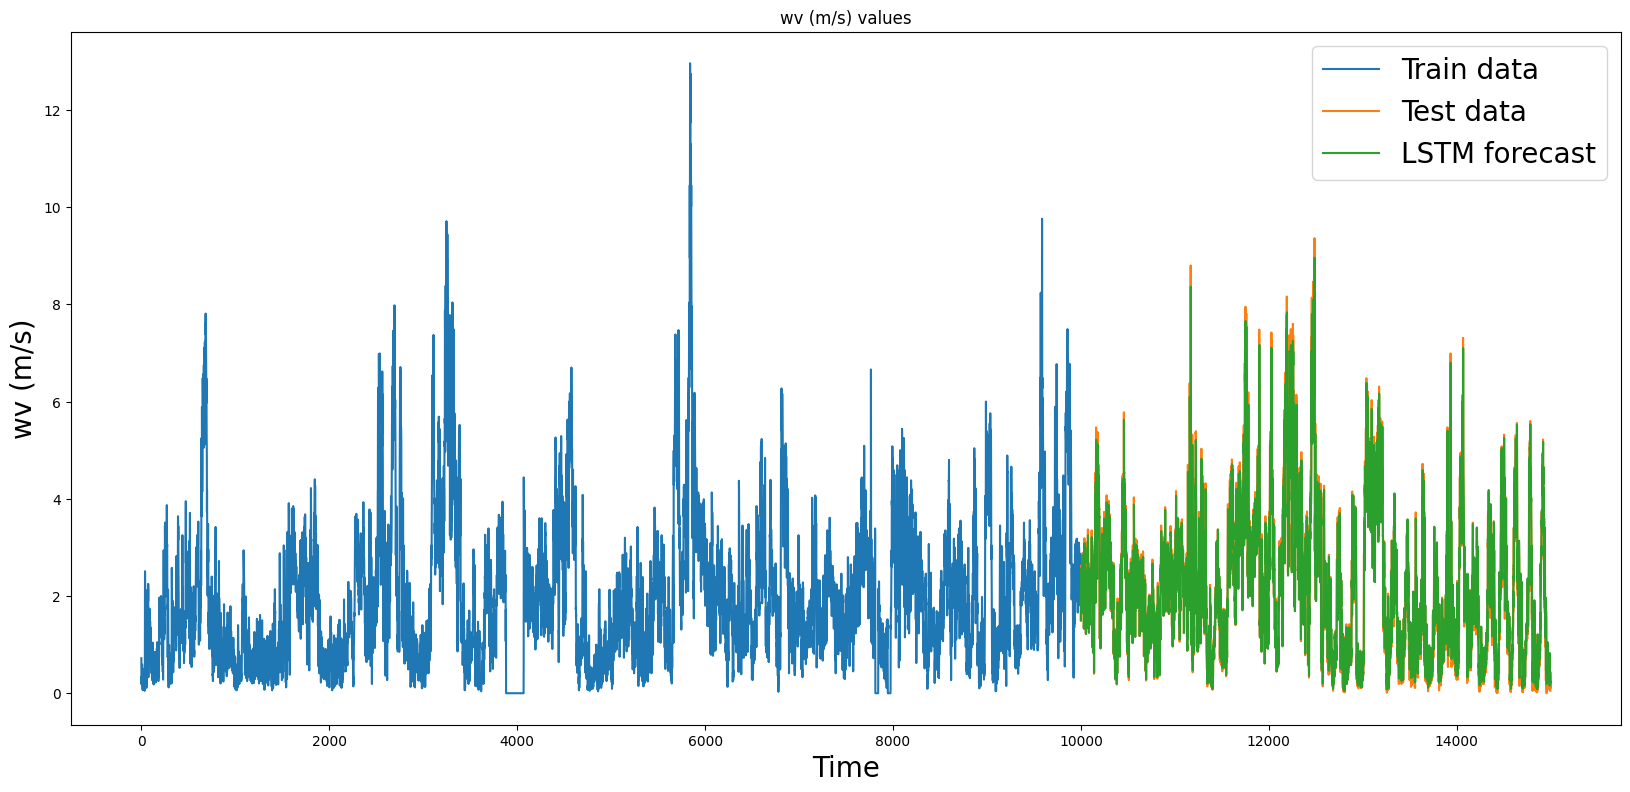

LSTM Metrics Date:
RMSE: 0.5698456420228567
MSE: 0.32472405573244173
SMAPE: 0.062
MAE: 0.4038155090655356
R^2: 0.8531728981439926


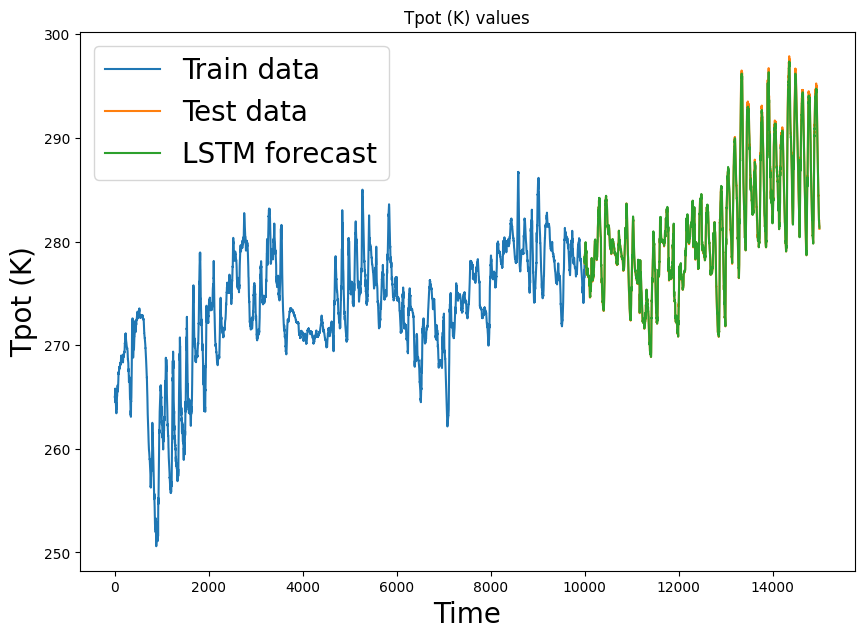

LSTM Metrics wv (m/s):
RMSE: 0.32204993519118663
MSE: 0.10371616075664751
SMAPE: 0.0
MAE: 0.21139080452809292
R^2: 0.9971104841902448


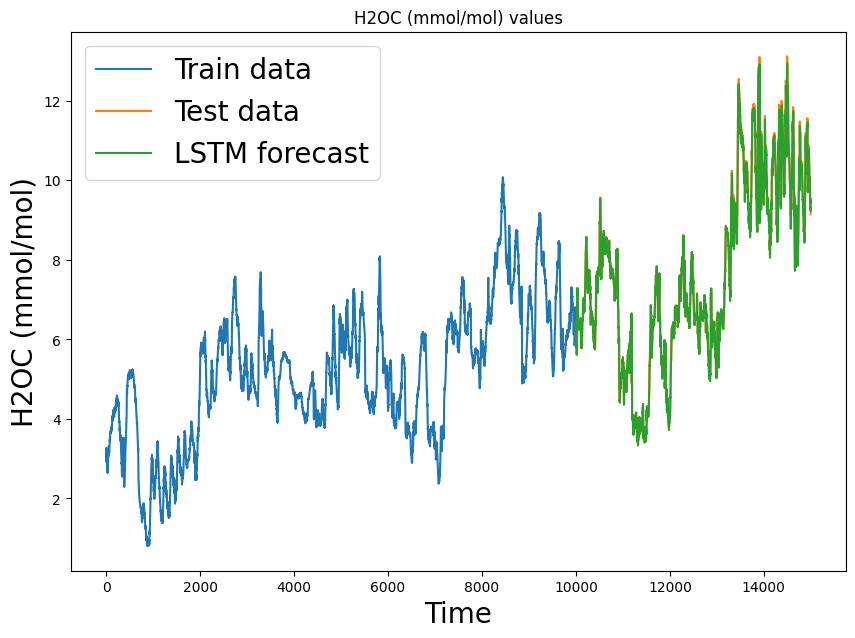

LSTM Metrics Tpot (K):
RMSE: 0.12230594989411706
MSE: 0.014958745379502272
SMAPE: 0.002
MAE: 0.07441051558318866
R^2: 0.996987367424852


In [316]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))


for k in range(len(columns_to_use)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='LSTM forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns_to_use[k]} values')
    plt.ylabel(f'{columns_to_use[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"LSTM Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))


Метрики модели демонстрируют высокую степень точности и эффективности в прогнозировании. RMSE, MSE и MAE, все находятся близко к нулю и меньше 1, что говорит о том, что различия между фактическими и прогнозируемыми значениями практически незаметны и подтверждают высокую точность модели. SMAPE также находится близко к нулю, подчеркивая высокую степень согласованности предсказаний с реальными данными.

Дополнительно, коэффициент детерминации R2, хотя и с небольшими погрешностями, также близок к идеальному значению. Это свидетельствует о том, что модель хорошо объясняет изменчивость целевых переменных и обладает высокой предсказательной силой.

Общий результат указывает на выдающуюся производительность модели и подтверждает ее способность к точному и надежному прогнозированию.

## GRU

In [277]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_gru_dataset(data, columns, lookback_window):
    """
    Создает обучающий набор данных для GRU.

    Parameters:
    - data (pd.DataFrame or np.ndarray): Исходный DataFrame или массив NumPy.
    - columns (list): Список столбцов для использования в обучающем наборе данных.
    - lookback_window (int): Размер окна истории.

    Returns:
    - x (np.ndarray): Входные данные для GRU.
    - y (np.ndarray): Целевые данные для GRU.
    """

    # Преобразование в DataFrame, если это массив NumPy
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=columns)

    # Создание DataFrame из выбранных столбцов
    df_gru = data[columns]

    # Преобразование в массив NumPy
    df_gru_array = df_gru.values

    # Инициализация MinMaxScaler для нормализации
    scaler = MinMaxScaler()

    # Подготовка данных для GRU
    x, y = [], []
    for i in range(lookback_window, len(df_gru_array)):
        x.append(df_gru_array[i - lookback_window:i])
        y.append(df_gru_array[i])
    
    # Преобразование в массивы NumPy
    x = np.array(x)
    y = np.array(y)

    return x, y

# Пример использования функции
lookback_window = 1

x, y = create_gru_dataset(df.values, columns_to_use, lookback_window)


In [278]:
x_train = x[0:10000]
y_train = y[0:10000]
x_test = x[10000:]
y_test = y[10000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 3)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3)).reshape(x_test.shape)


In [279]:
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras import Input, Model

def build_gru_model(lookback_window, num_features, units=90):
    """
    Строит модель GRU.

    Parameters:
    - lookback_window (int): Размер окна истории.
    - num_features (int): Количество признаков в каждом временном шаге.
    - units (int): Количество нейронов в слое GRU.

    Returns:
    - model (tf.keras.Model): Построенная модель GRU.
    """

    # Входной слой
    i = Input(shape=(lookback_window, num_features))

    # GRU слой
    m = GRU(units=units, activation='tanh', return_sequences=False)(i)

    # Полносвязный слой
    m = Dense(num_features, activation='linear')(m)

    # Создание модели
    model = Model(inputs=[i], outputs=[m])

    return model

# Размер окна истории и количество признаков
lookback_window = 1
num_features = 3

# Построение модели GRU
model_gru = build_gru_model(lookback_window, num_features)

# Вывод структуры модели
model_gru.summary()

# Компиляция модели GRU
model_gru.compile(optimizer='adam', loss='mae')


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 1, 3)]            0         
                                                                 
 gru_2 (GRU)                 (None, 90)                25650     
                                                                 
 dense_21 (Dense)            (None, 3)                 273       
                                                                 
Total params: 25923 (101.26 KB)
Trainable params: 25923 (101.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [281]:
model_gru.fit(x_train_scaled, y_train_scaled, epochs=30, verbose=0)
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 3))

157/157 [==============================] - 0s 3ms/step


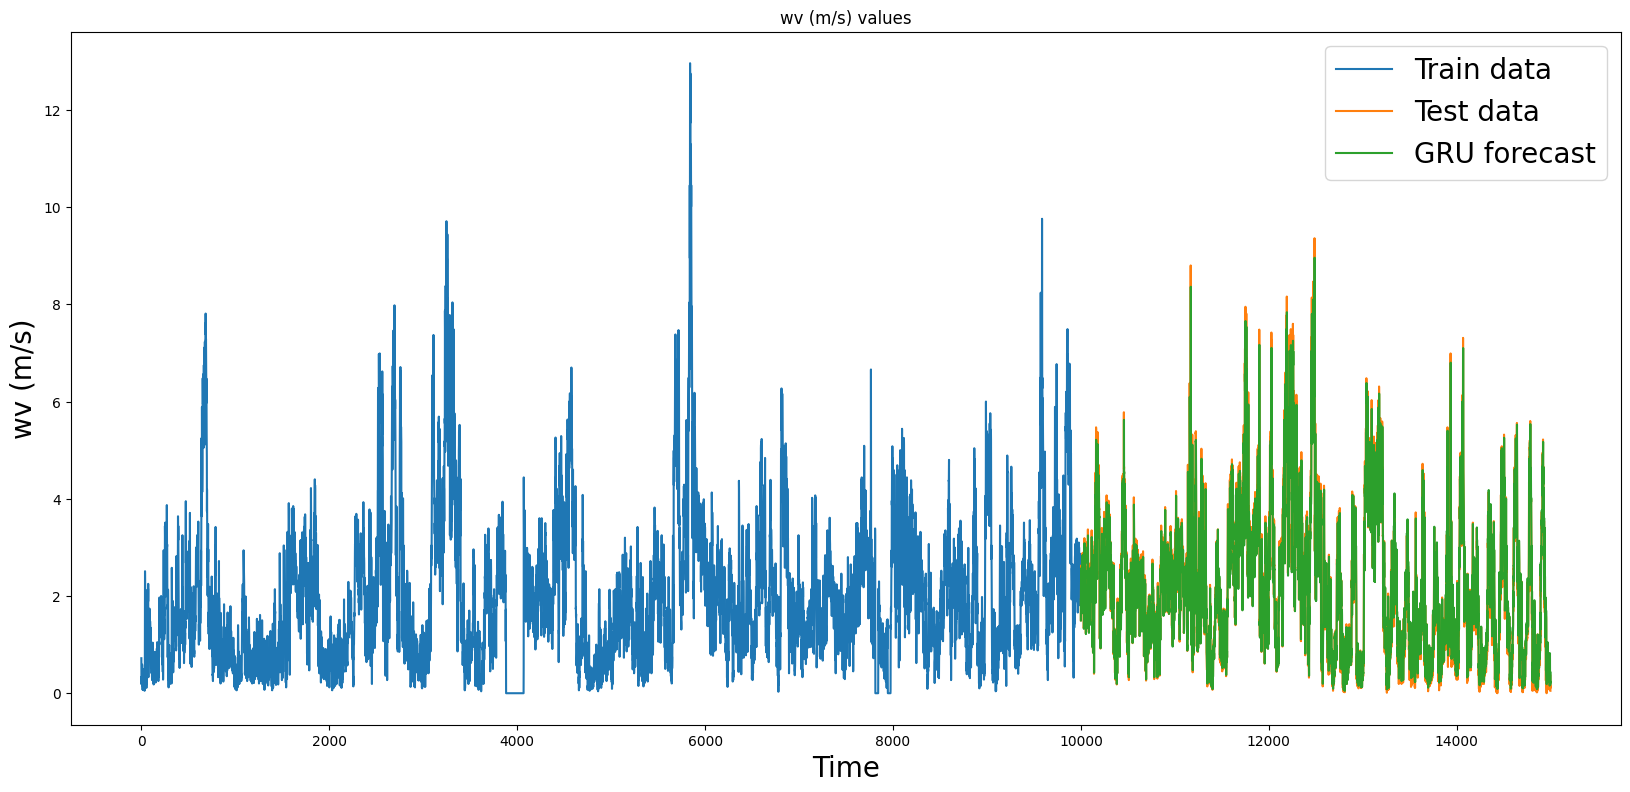

LSTM Metrics Date:
RMSE: 0.5698456420228567
MSE: 0.32472405573244173
SMAPE: 0.062
MAE: 0.4038155090655356
R^2: 0.8531728981439926


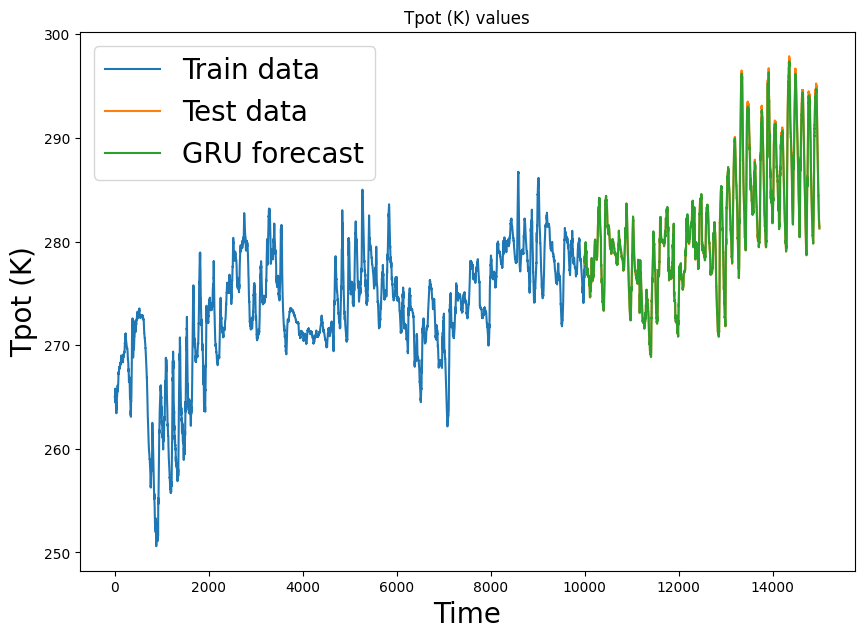

LSTM Metrics wv (m/s):
RMSE: 0.32204993519118663
MSE: 0.10371616075664751
SMAPE: 0.0
MAE: 0.21139080452809292
R^2: 0.9971104841902448


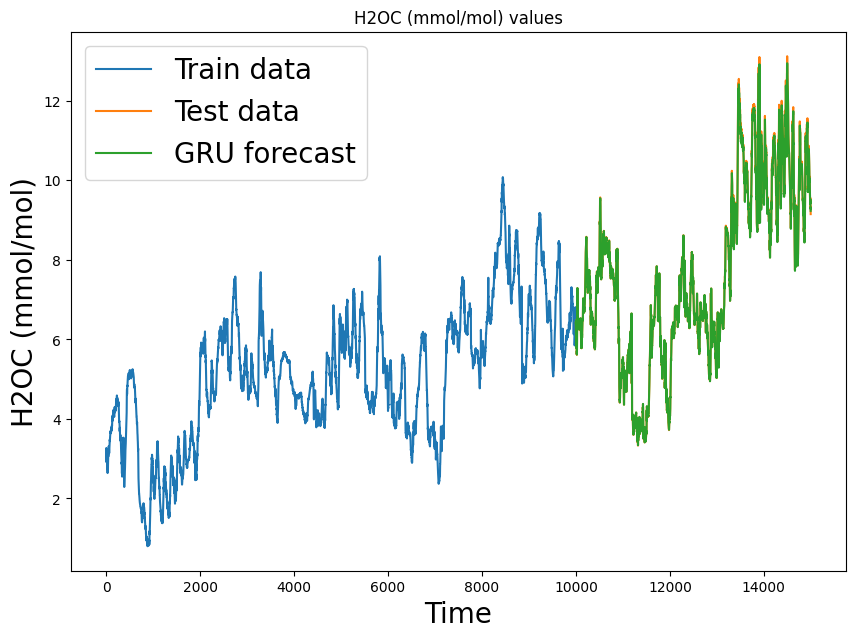

LSTM Metrics Tpot (K):
RMSE: 0.12230594989411706
MSE: 0.014958745379502272
SMAPE: 0.002
MAE: 0.07441051558318866
R^2: 0.996987367424852


In [320]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))


for k in range(len(columns_to_use)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='GRU forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns_to_use[k]} values')
    plt.ylabel(f'{columns_to_use[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"LSTM Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))


Модель продемонстрировала выдающееся качество согласования с фактическими данными, подтвержденное низкими значениями метрик. RMSE, MSE и MAE, все близки к нулю и меньше 1, что свидетельствует о практически нулевой разнице между предсказанными и фактическими значениями, что является почти идеальным результатом. Аналогично, SMAPE также стремится к нулю, подчеркивая высокую точность модели.

Кроме того, коэффициент детерминации R2, несмотря на небольшие отклонения, приближен к идеальному значению, указывая на то, что модель эффективно объясняет изменчивость в целевых данных.

Обобщенно, результаты GRU и LSTM схожи, что подтверждает эффективность обеих моделей в предсказании временных рядов.







## TCN


TCN (Temporal Convolutional Network) представляет собой архитектуру нейронной сети, основанную на операциях свертки, предназначенную для обработки последовательных данных, таких как временные ряды или текст. TCN разработан для эффективного извлечения и моделирования долгосрочных зависимостей в последовательных данных.

In [284]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_tcn_dataset(data, columns, lookback_window):
    """
    Создает обучающий набор данных для TCN.

    Parameters:
    - data (pd.DataFrame or np.ndarray): Исходный DataFrame или массив NumPy.
    - columns (list): Список столбцов для использования в обучающем наборе данных.
    - lookback_window (int): Размер окна истории.

    Returns:
    - x (np.ndarray): Входные данные для TCN.
    - y (np.ndarray): Целевые данные для TCN.
    """

    # Преобразование в DataFrame, если это массив NumPy
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=columns)

    # Создание DataFrame из выбранных столбцов
    df_tcn = data[columns]

    # Преобразование в массив NumPy
    df_tcn_array = df_tcn.values

    # Инициализация MinMaxScaler для нормализации
    scaler = MinMaxScaler()

    # Подготовка данных для TCN
    x, y = [], []
    for i in range(lookback_window, len(df_tcn_array)):
        x.append(df_tcn_array[i - lookback_window:i])
        y.append(df_tcn_array[i])
    
    # Преобразование в массивы NumPy
    x = np.array(x)
    y = np.array(y)

    return x, y

# Пример использования функции
lookback_window = 1

x_tcn, y_tcn = create_tcn_dataset(df.values, columns_to_use, lookback_window)


In [285]:
x_train = x[0:10000]
y_train = y[0:10000]
x_test = x[10000:]
y_test = y[10000:]


In [286]:
from tcn import TCN
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

def build_tcn_model(lookback_window, num_features, units=90):
    """
    Строит модель TCN.

    Parameters:
    - lookback_window (int): Размер окна истории.
    - num_features (int): Количество признаков в каждом временном шаге.
    - units (int): Количество нейронов в слое TCN.

    Returns:
    - model (tf.keras.Model): Построенная модель TCN.
    """

    # Входной слой
    i = Input(shape=(lookback_window, num_features))

    # Слой TCN
    m = TCN(nb_filters=units, kernel_size=2, dilations=[1, 2, 4, 8, 16, 32], use_skip_connections=True)(i)

    # Полносвязный слой
    m = Dense(num_features, activation='linear')(m)

    # Создание модели
    model = Model(inputs=[i], outputs=[m])

    return model

# Размер окна истории и количество признаков
lookback_window = 1
num_features = 3

# Построение модели TCN
model_tcn = build_tcn_model(lookback_window, num_features)

# Вывод структуры модели
model_tcn.summary()

# Компиляция модели TCN
model_tcn.compile(optimizer='adam', loss='mae')


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 1, 3)]            0         
                                                                 
 tcn_9 (TCN)                 (None, 90)                180180    
                                                                 
 dense_22 (Dense)            (None, 3)                 273       
                                                                 
Total params: 180453 (704.89 KB)
Trainable params: 180453 (704.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [287]:
model.fit(x_train_scaled, y_train_scaled, epochs=70, verbose=0)
y_pred_scaled = model.predict(x_test_scaled)

157/157 [==============================] - 0s 2ms/step


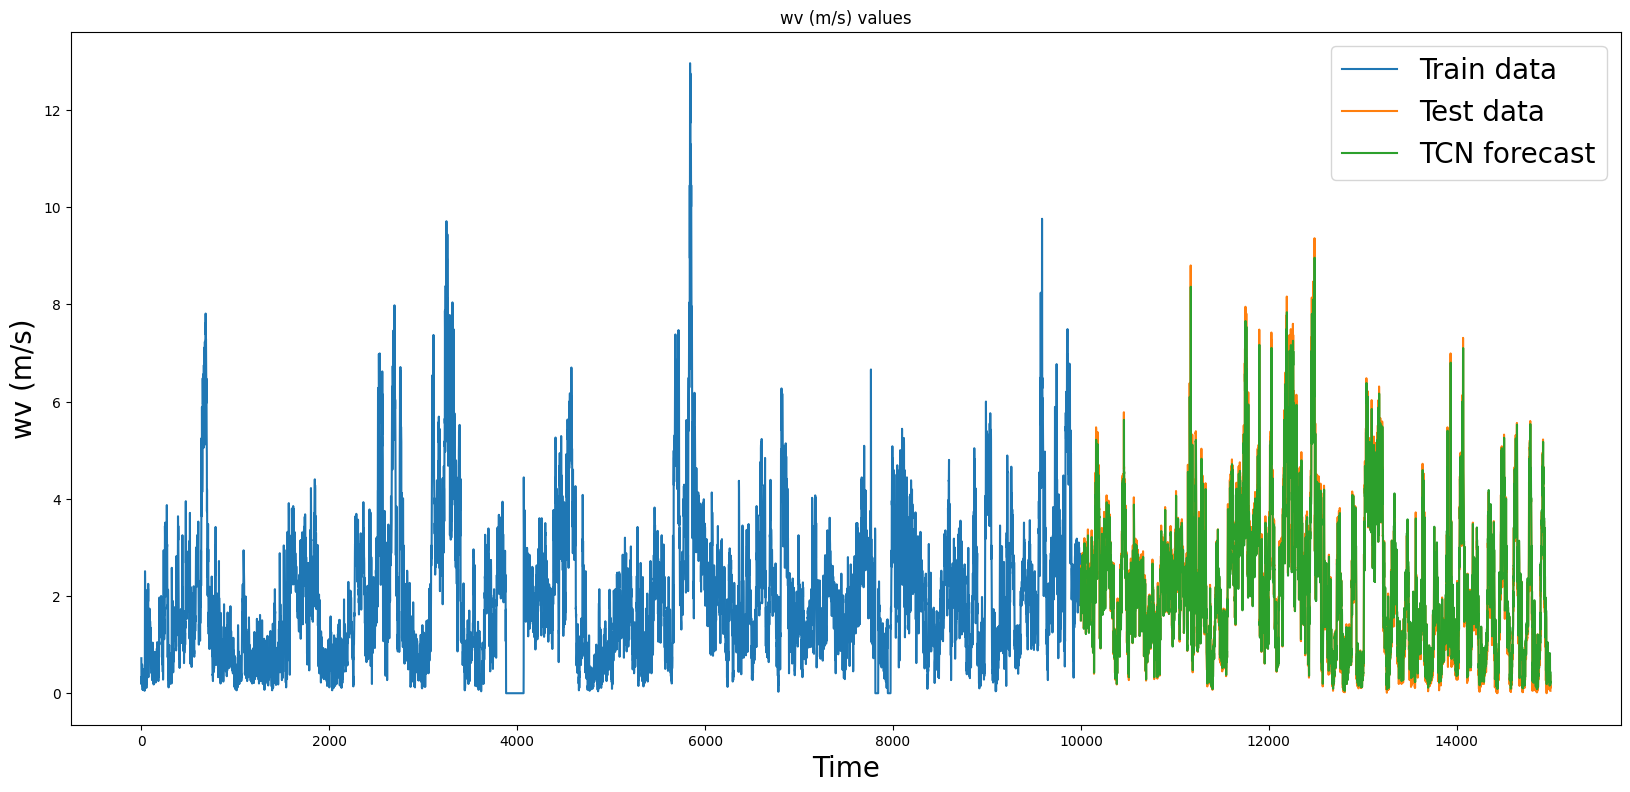

LSTM Metrics Date:
RMSE: 0.5698456420228567
MSE: 0.32472405573244173
SMAPE: 0.062
MAE: 0.4038155090655356
R^2: 0.8531728981439926


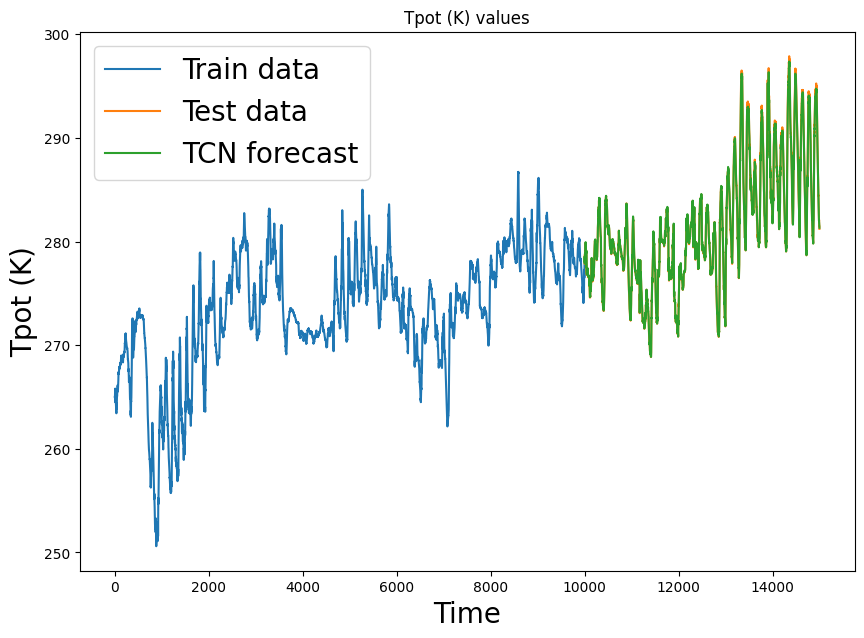

LSTM Metrics wv (m/s):
RMSE: 0.32204993519118663
MSE: 0.10371616075664751
SMAPE: 0.0
MAE: 0.21139080452809292
R^2: 0.9971104841902448


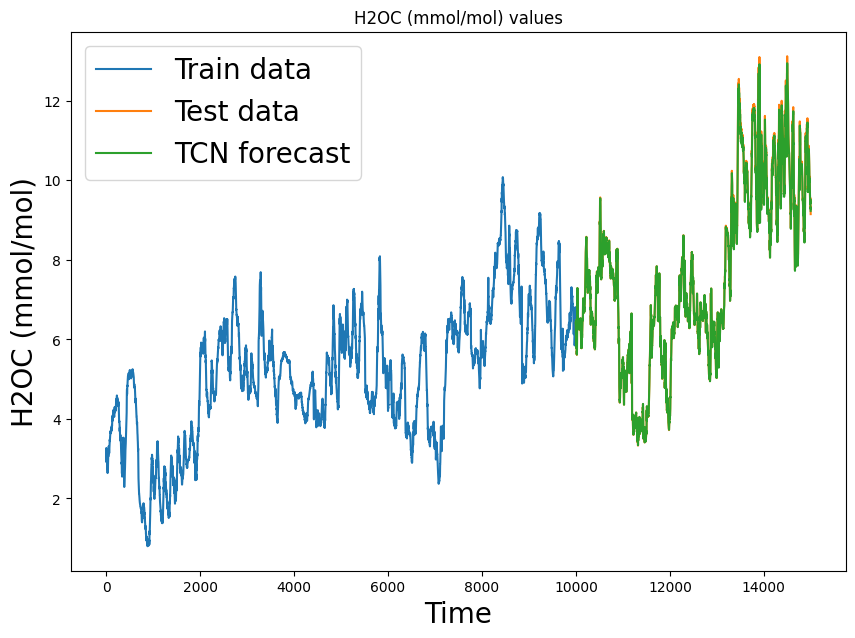

LSTM Metrics Tpot (K):
RMSE: 0.12230594989411706
MSE: 0.014958745379502272
SMAPE: 0.002
MAE: 0.07441051558318866
R^2: 0.996987367424852


In [319]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))


for k in range(len(columns_to_use)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='TCN forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns_to_use[k]} values')
    plt.ylabel(f'{columns_to_use[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"LSTM Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))